# Analysis Exp. 2 - Scene recognition endpoints

In [1]:
import os, sys

# Local modules
sys.path.append('./..')
import data_processing
import visualization
import stats

# Data management
import pandas as pd 
import numpy as np
import scipy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Patch
import dataframe_image as dfi

# Suppress pandas future-warning about categorical dtypes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load experimental data

In [2]:
# Specify which data to load
data_dir = data_processing.DATA_DIR_EXP2
subjects = data_processing.SUBJECTS_EXP2 # or specify subset of subjects
practice_trials = data_processing.PRACTICE_TRIALS_EXP2
data_keys = ['TrialConfigRecord'] # which type of data to load
experimental_tasks = ['SceneRecognition']

# Get Filenames
exp_filenames, clbr_filenames = data_processing.get_filenames(data_dir = data_dir,
                                                              subjects= subjects, 
                                                              data_keys = data_keys) 

# Load raw data 
exp_data = data_processing.load_data_from_filenames(exp_filenames)

# Process into useful format
data_processing.reformat_data(exp_data)

# Select the experimental trials with scene recognition task
# Only need the config. record data saved after each trial (exp. conditions, trial duration, scene-recognition response, etc.)
sr_data = data_processing.drop_invalid(exp_data['TrialConfigRecord'],
                                       exclude_trials = practice_trials,
                                       include_tasks = experimental_tasks,
                                       include_subjects = subjects)
sr_data = sr_data.astype({'ReportedSubjectiveRating':float, 'ReportedEventsCount':float}) # convert int to float dtype

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


In [3]:
display(sr_data.head(5))

,ExperimentalTask,GazeCondition,EnvironmentName,EnvironmentClass,Glasses,GazeRaySensitivity,DataDelimiter,ReportedRoomCategory,ReportedSubjectiveRating,ReportedEventsCount,TrialDuration,Unnamed: 11,Subject,Block,RelativeTrialNumber,TrialIdentifier
9,SceneRecognition,GazeAssistedSampling,kitchen_3,Kitchen,NaN,1.0,,Kitchen,2.0,1.0,39.04846,NaN,S35,1,1,S35B1T1
10,SceneRecognition,GazeAssistedSampling,bedroom_2,Bedroom,NaN,1.0,,Bedroom,3.0,1.0,22.35693,NaN,S35,1,2,S35B1T2
11,SceneRecognition,GazeAssistedSampling,living_4,Living,NaN,1.0,,Living,2.0,1.0,80.98950,NaN,S35,1,3,S35B1T3
13,SceneRecognition,GazeIgnored,living_2,Living,NaN,1.0,,Living,2.0,1.0,65.68115,NaN,S35,2,1,S35B2T1
14,SceneRecognition,GazeIgnored,bedroom_4,Bedroom,NaN,1.0,,Bedroom,1.0,0.0,90.00293,NaN,S35,2,2,S35B2T2


## Data analysis

In [4]:
# Create output directory for saving intermediate and final results
if not os.path.exists('./out'):
    os.makedirs('./out')

### Calculate correct responses

In [5]:
# Previous observations and classification success as additional columns
sr_data['SeenBeforeCount'] = sr_data.groupby(['Subject', 'EnvironmentName']).cumcount()
sr_data['CorrectResponse'] = (sr_data.EnvironmentClass == sr_data.ReportedRoomCategory).astype(float)
sr_data['Session'] = (sr_data.Block>3).replace({False: 'FirstSession', True: 'SecondSession' })

# Save intermediate results
sr_data.to_csv('out/scene_recognition_trial_endpoints.tsv', sep='\t', index=False)

### Data inspection (per subject)

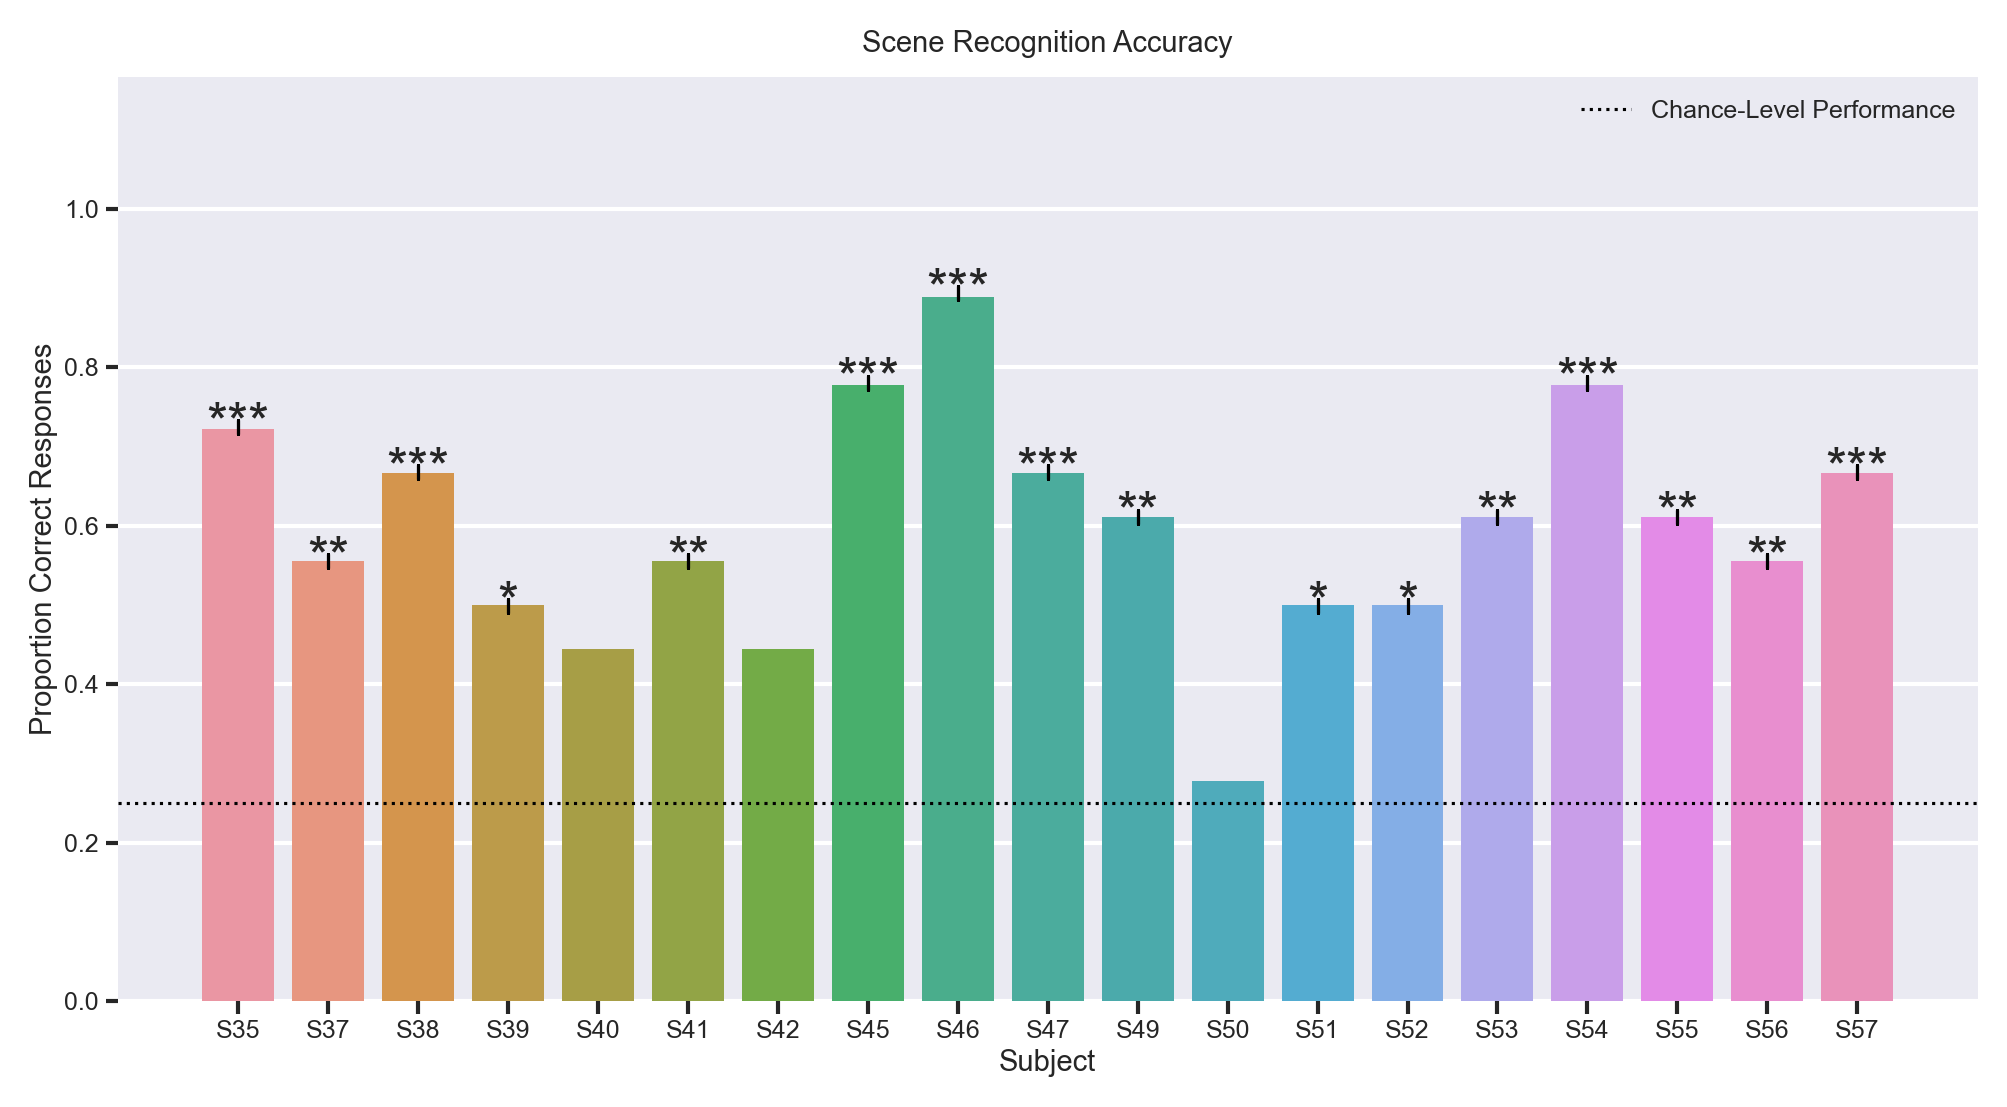

In [6]:
# Barplot per subject
visualization.set_figurestyle()
fig, ax = visualization.create_subplots(1, figsize=(8,4))
sns.barplot(x='Subject', y='CorrectResponse', data=sr_data, errorbar=None, ax=ax)
ax.set(title='Scene Recognition Accuracy', ylabel='Proportion Correct Responses')
h = ax.axhline(0.25, color='k', linestyle=':', label='Chance-Level Performance')
ax.legend(handles=[h,])

# Binomial test (significantly better than chance?)
correct_responses = sr_data.groupby('Subject')[['CorrectResponse']]
p_values = stats.binom_test(n_correct=correct_responses.sum(), n_total=correct_responses.count(), p=0.25)

# Draw significance stars
stars = p_values.apply(stats.count_significance_stars, alpha=0.05)
n_subjects = len(correct_responses)
visualization.add_significance_lines(ax,
                               text=stars.replace({'n.s.': None}).values,
                               x_pairs=[(i,i) for i in range(n_subjects)],
                               rel_y=0.87*correct_responses.mean().values,)

plt.savefig('out/scene_recognition_accuracy_per_subject.png')

## Statistical analysis

In [7]:
# # In case resuming the analysis from here, uncomment to load previously-saved intermediate results.
# sr_data = pd.read_csv('out/scene_recognition_trial_endpoints.tsv',sep='\t').set_index('TrialIdentifier')

In [8]:
exclude_subjects = ['S40', 'S42', 'S50']
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

# Average over subjects 
avg = stats.average(sr_data, y=endpoints, group='Subject', x='GazeCondition')
if exclude_subjects is not None:
    avg = avg.loc[~avg.Subject.isin(exclude_subjects)]
    print(f'excluding {len(exclude_subjects)} subjects: {exclude_subjects}\n')

# Normality test
normality = stats.normality_test(avg, endpoints=endpoints)
non_normal_endpoints = [y for y in endpoints if normality.loc['AnyNonNormal', y]]
normal_endpoints = [y for y in endpoints if not normality.loc['AnyNonNormal', y]]
display('Normality test:',  stats.style(normality))

# Non-parametric tests
results_wilcoxon = pd.DataFrame()
if non_normal_endpoints:
    results_wilcoxon = stats.paired_test(avg, group='Subject', endpoints=non_normal_endpoints, test='Wilcoxon')
    # display('Results Wilcoxon:', stats.style(results_wilcoxon, alpha=0.05/3)) # Alpha corrected for multiple comparisons

# Parametric tests
results_t_test = pd.DataFrame()
if normal_endpoints:
    results_t_test = stats.paired_test(avg, group='Subject', endpoints=normal_endpoints, test='t-test')
    # display('Results t-test:', stats.style(results_t_test, alpha=0.05/3))

# All Results
stat_results = pd.concat([results_wilcoxon, results_t_test], axis=1)[endpoints]
display('Statistical results (merged non-param. + param. tests):', stats.style(stat_results, alpha=0.05/3))

excluding 3 subjects: ['S40', 'S42', 'S50']



'Normality test:'

,CorrectResponse,TrialDuration,ReportedSubjectiveRating
GazeAssistedSampling,0.020388,0.445381,0.859902
GazeIgnored,0.044697,0.082303,0.121256
SimulationFixedToGaze,0.060432,0.784777,0.725368
AnyNonNormal,True,False,False


C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Jaap\Anaconda3\envs\SPVGaze\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


'Statistical results (merged non-param. + param. tests):'

,CorrectResponse,TrialDuration,ReportedSubjectiveRating
Comparison,,,
Gaze Locked <> Gaze Contingent,0.577116,0.001211,0.000060
Gaze Contingent <> Gaze Ignored,0.006724,0.060690,0.015627
Gaze Locked <> Gaze Ignored,0.011874,0.000350,0.000047


In [9]:
# Save results
avg.to_csv('out/scene_recognition_averaged_endpoints.tsv', sep='\t')
normality.to_csv('out/scene_recognition_normality_test.tsv', sep='\t')
stat_results.to_csv('out/scene_recognition_paired_testing.tsv', sep='\t')
dfi.export(stat_results, 'out/stats_scene_recognition.png')

### Visualization

In [4]:
# # In case resuming the analysis from here, uncomment to load previously-saved results.
# avg = pd.read_csv('out/scene_recognition_averaged_endpoints.tsv', sep='\t')
# normality = pd.read_csv('out/scene_recognition_normality_test.tsv', sep='\t')
# stat_results = pd.read_csv('out/scene_recognition_paired_testing.tsv', sep='\t').set_index('Comparison')

In [20]:
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

# Display main results in table format (mean and standard deviation)
main_table = avg.groupby('GazeCondition')[endpoints].mean()
display(main_table.rename(index=visualization.COND_REDEFINED)) # (Use clean typography for gaze conditions)

# Display significant comparisons
stars = stat_results.applymap(stats.count_significance_stars)
display(stars)

,CorrectResponse,TrialDuration,ReportedSubjectiveRating
GazeCondition,,,
Gaze Contingent,0.572917,51.425032,4.270833
Gaze Ignored,0.791667,44.078206,4.864583
Gaze Locked,0.541667,63.024539,3.135417


,CorrectResponse,TrialDuration,ReportedSubjectiveRating
Comparison,,,
Gaze Locked <> Gaze Contingent,n.s.,**,***
Gaze Contingent <> Gaze Ignored,*,n.s.,*
Gaze Locked <> Gaze Ignored,*,**,***


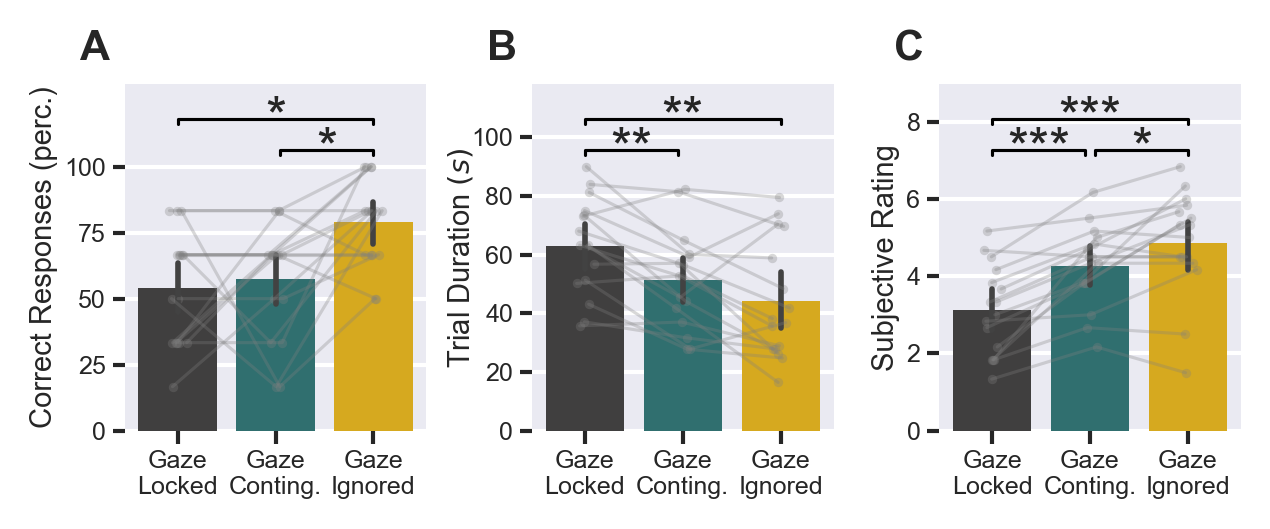

In [26]:
# Visualization parameters
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating'] 
titles = ['', '', '']
y_lbls = ['Correct Responses (perc.)', 'Trial Duration $(s)$', 'Subjective Rating']

# Express corr. responses as percentage
if avg['CorrectResponse'].max() <=1.:
    avg['CorrectResponse'] *=100  

# Set default figurestyle
visualization.set_figurestyle()

# Plot barplots and plot swarm overlay
fig,axs = visualization.create_subplots(figsize=(8*3/5,1.5))
fig,axs = visualization.bar_plots(avg, endpoints, fig=fig, axs=axs)
visualization.swarm_plots(avg, endpoints, group = 'Subject', axs=axs, fig=fig)
visualization.redefine_x_ticks(axs, remove_xlabel=True, new_line=True) # Clean terminology/typography for gaze conditions

# Apply visualization parameters (titles, labels, etc.)
for i, ax in enumerate(axs.flatten()):
    axs[i].set(title=titles[i],#'', #title=titles[i],
               ylabel=y_lbls[i],
               xticklabels = ['Gaze\nLocked', 'Gaze\nConting.', 'Gaze\nIgnored'])

    # Add significance lines
    visualization.add_significance_lines(axs[i], stars.replace({'n.s.': None}).iloc[:,i].values,
                               x_pairs=[(0,.95),(1.05,2.),(0,2.)],
                               rel_y=[0.81, 0.81, 0.9],)

# Some additional custom adjustments
axs[0].set_yticks(np.linspace(0,100,5))
axs[1].set_ylabel(y_lbls[1],labelpad=-1)
visualization.add_panel_index(axs[0],'A')
visualization.add_panel_index(axs[1],'B')
visualization.add_panel_index(axs[2],'C')

# Save figure
plt.savefig('out/scene_recognition_endpoints.png', bbox_inches='tight')

### Additional analyses - Training effects

In [27]:
# # load data 
# sr_data = pd.read_csv('out/scene_recognition_trial_endpoints.tsv',sep='\t').set_index('TrialIdentifier')

endpoints=['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

#### First versus second scene recognition session

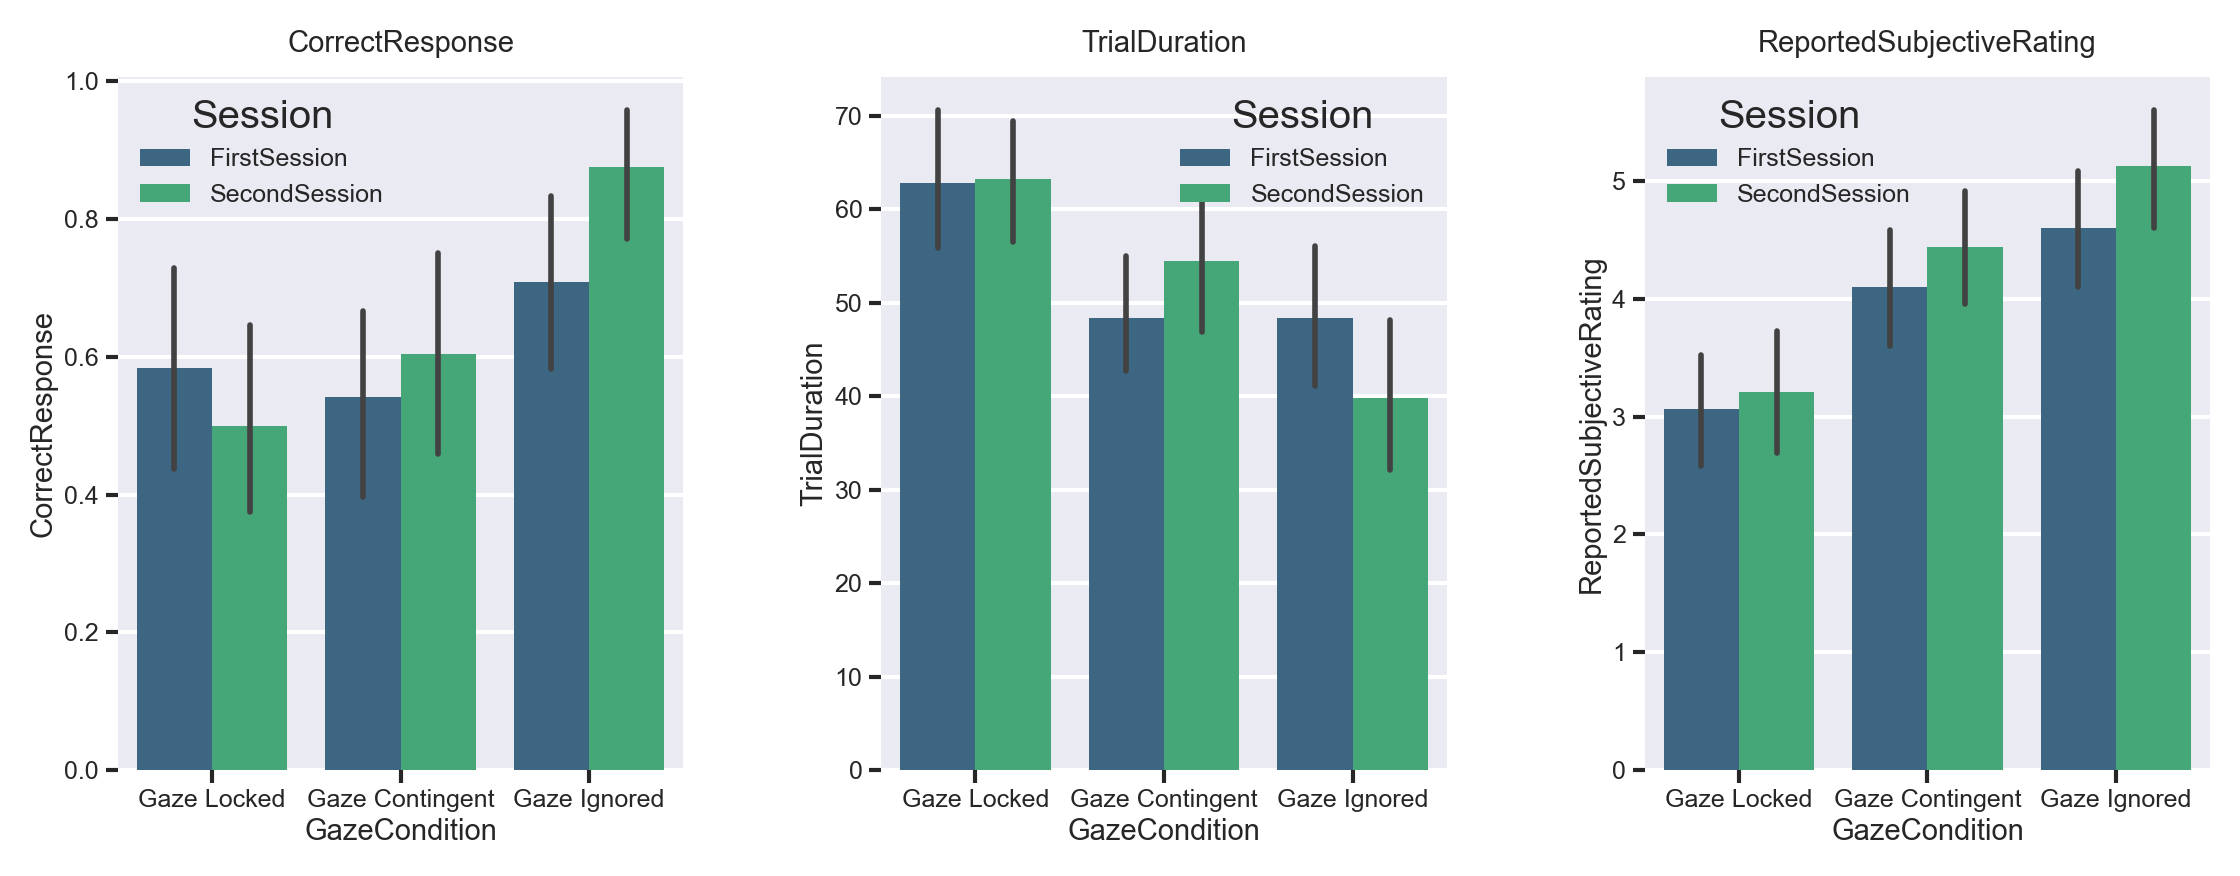

In [31]:
exclude_subjects = ['S40', 'S42', 'S50']
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']

data = sr_data.copy()
if exclude_subjects is not None:
    data = data.loc[~data.Subject.isin(exclude_subjects)].copy()

visualization.set_figurestyle()
fig, axs = visualization.create_subplots(figsize=(9,3))
visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='Session', palette='viridis', fig=fig, axs=axs)
visualization.redefine_x_ticks(axs)

#### Revisiting the same environment

In [34]:
endpoints = ['CorrectResponse', 'TrialDuration', 'ReportedSubjectiveRating']
exclude_subjects = ['S40', 'S42', 'S50']

data = sr_data.copy()
if exclude_subjects is not None:
    data = data.loc[~data.Subject.isin(exclude_subjects)].copy()
    
avg_seenbefore = data.loc[sr_data.Session == 'SecondSession'].groupby(['Subject']).SeenBeforeCount.sum().mean()
print(f'on average, {avg_seenbefore:.2f} of the 9 environments in the second session were seen before')

on average, 7.00 of the 9 environments in the second session were seen before


Text(0.5, 0.98, 'Second session')

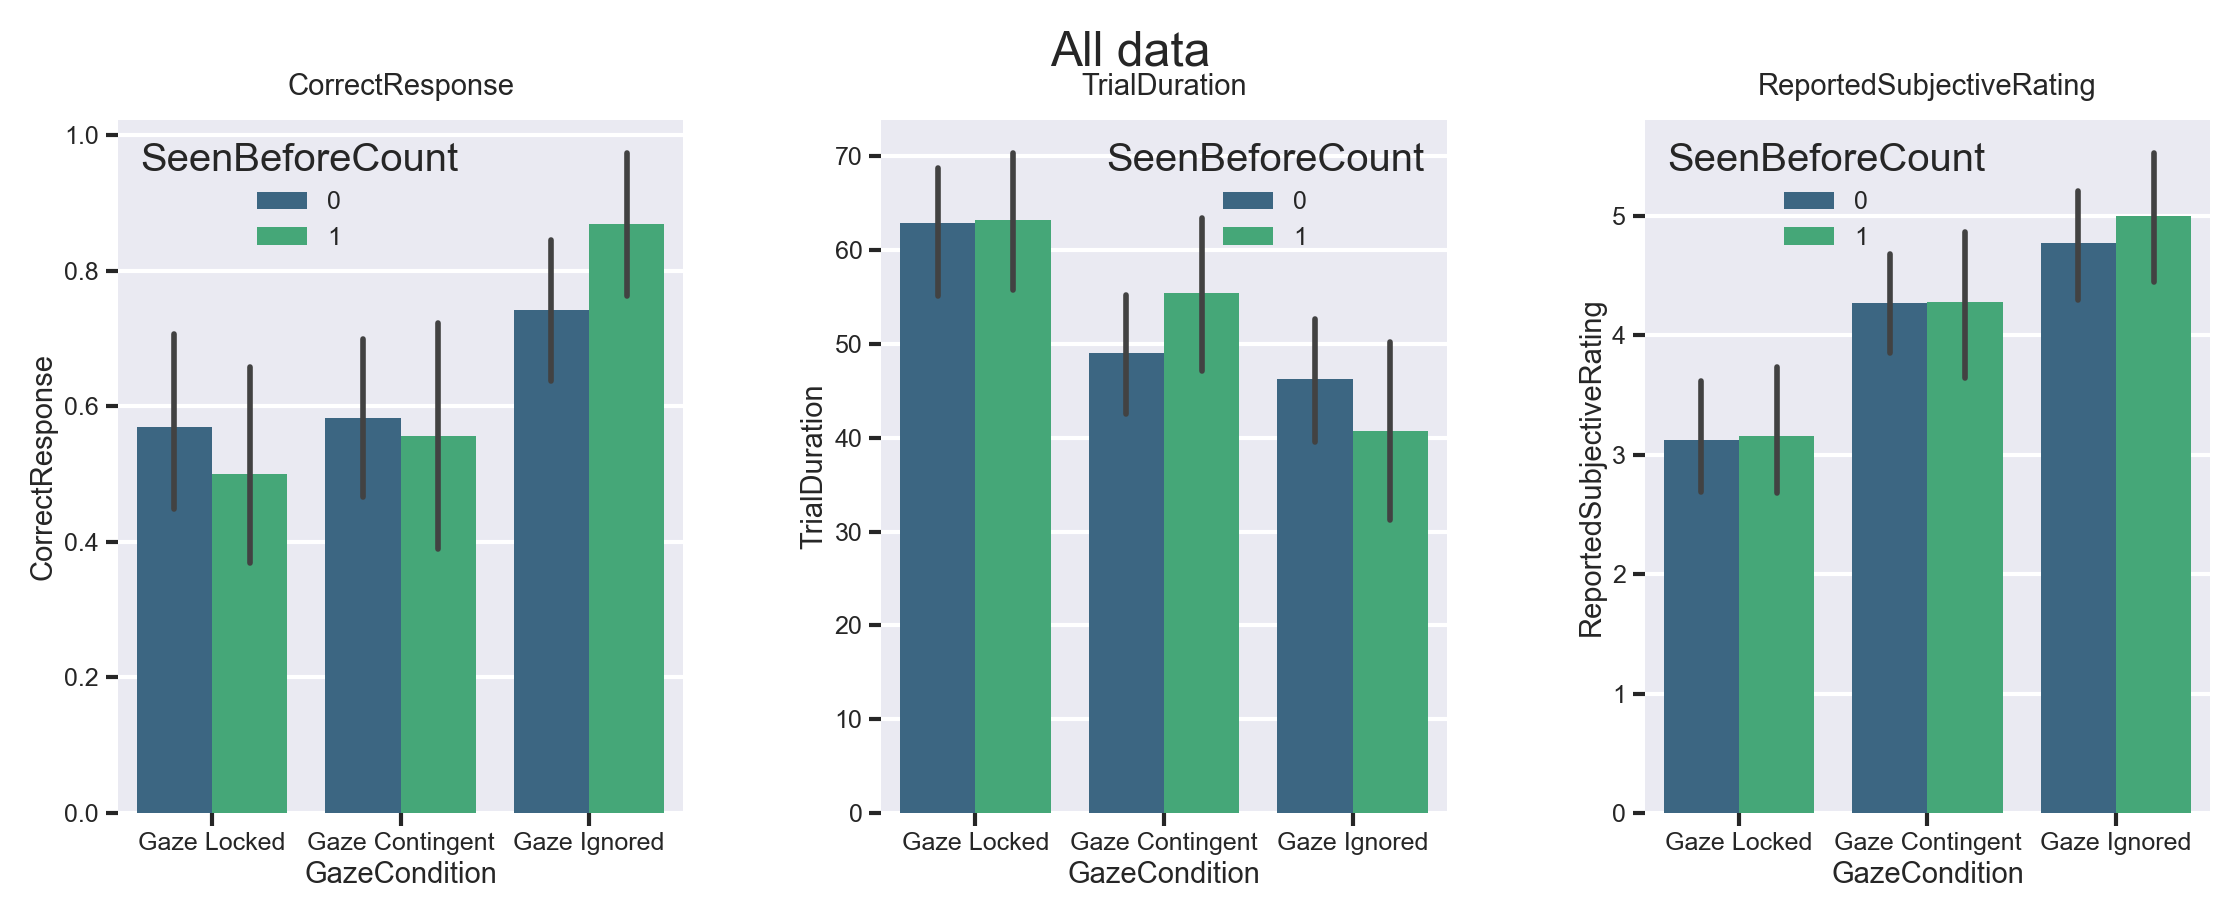

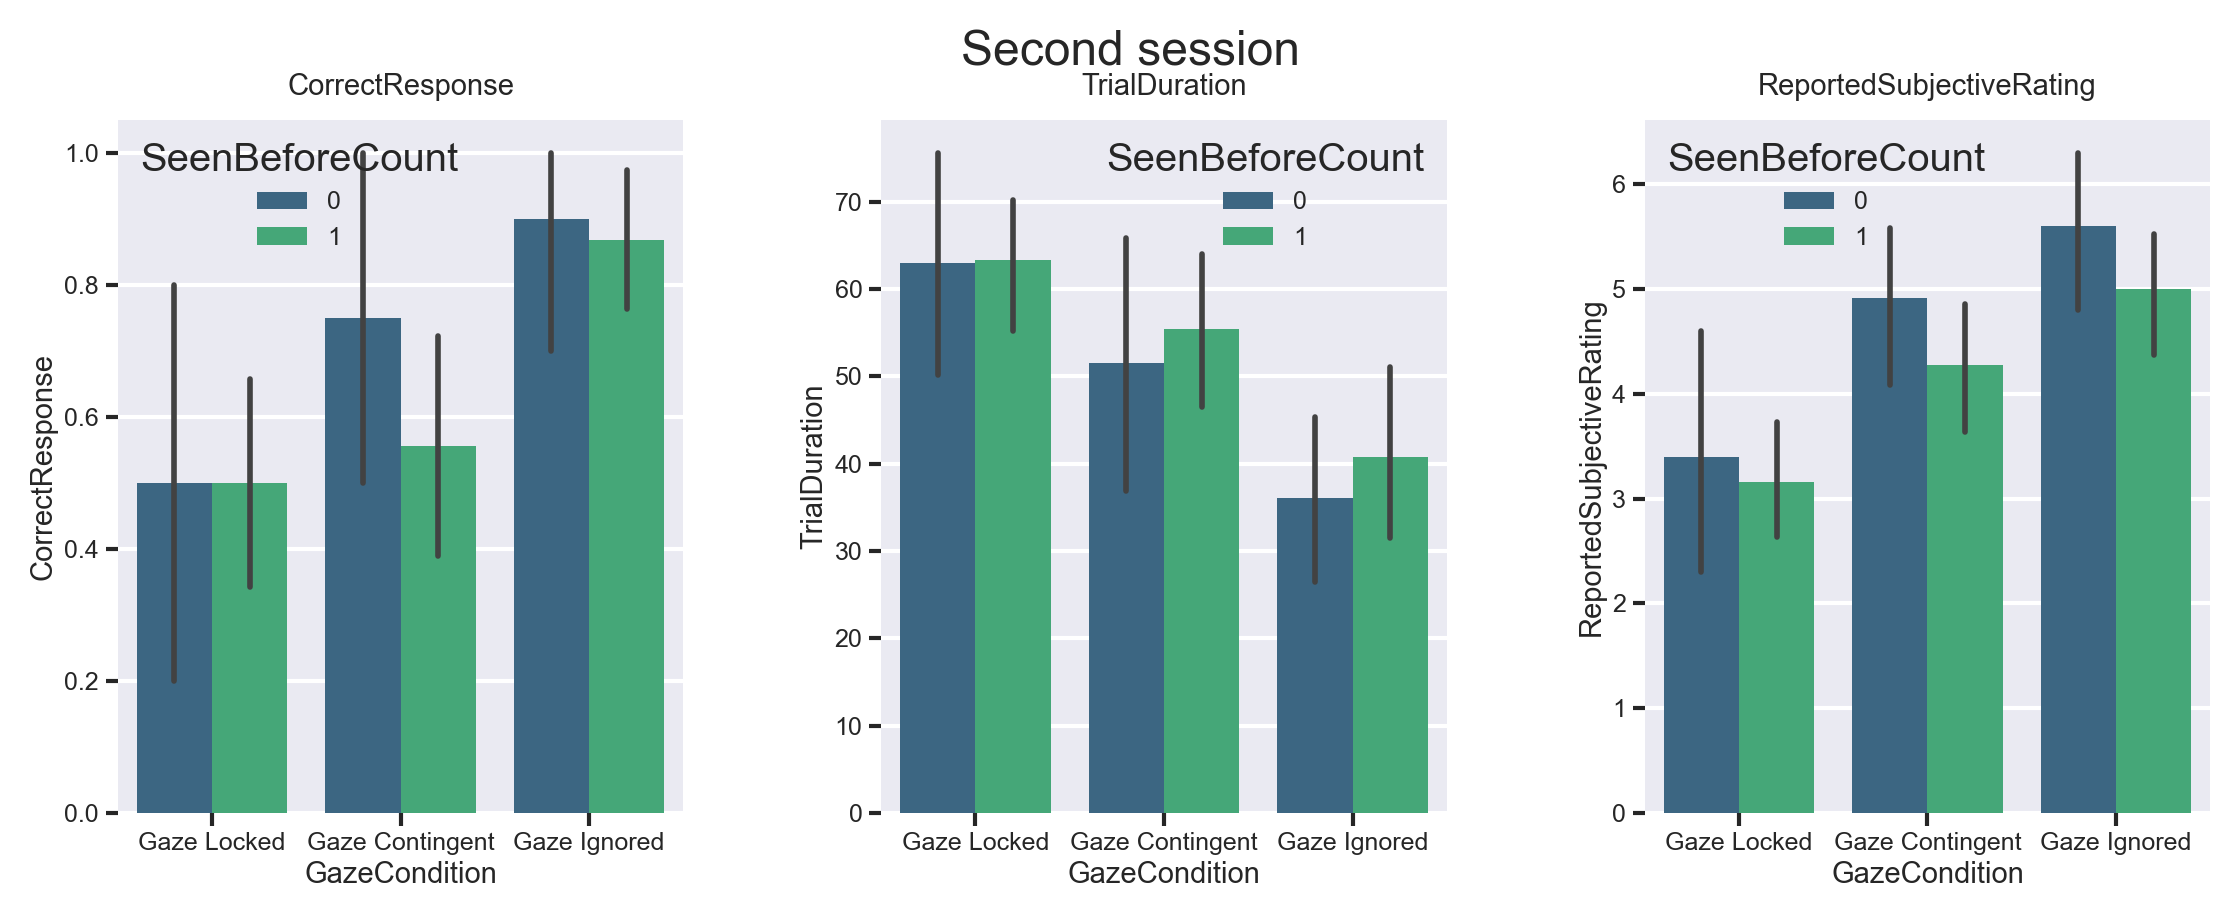

In [35]:
visualization.set_figurestyle()

fig, axs = visualization.create_subplots(figsize=(9,3))
visualization.bar_plots(data=data, x='GazeCondition', endpoints=endpoints, hue='SeenBeforeCount',
                        palette='viridis', fig=fig, axs=axs)
visualization.redefine_x_ticks(axs)
fig.suptitle('All data')

fig, axs = visualization.create_subplots(figsize=(9,3))
visualization.bar_plots(data=data.loc[data.Session =='SecondSession'], x='GazeCondition', endpoints=endpoints,
                        hue='SeenBeforeCount', palette='viridis', fig=fig, axs=axs)
visualization.redefine_x_ticks(axs)
fig.suptitle('Second session')

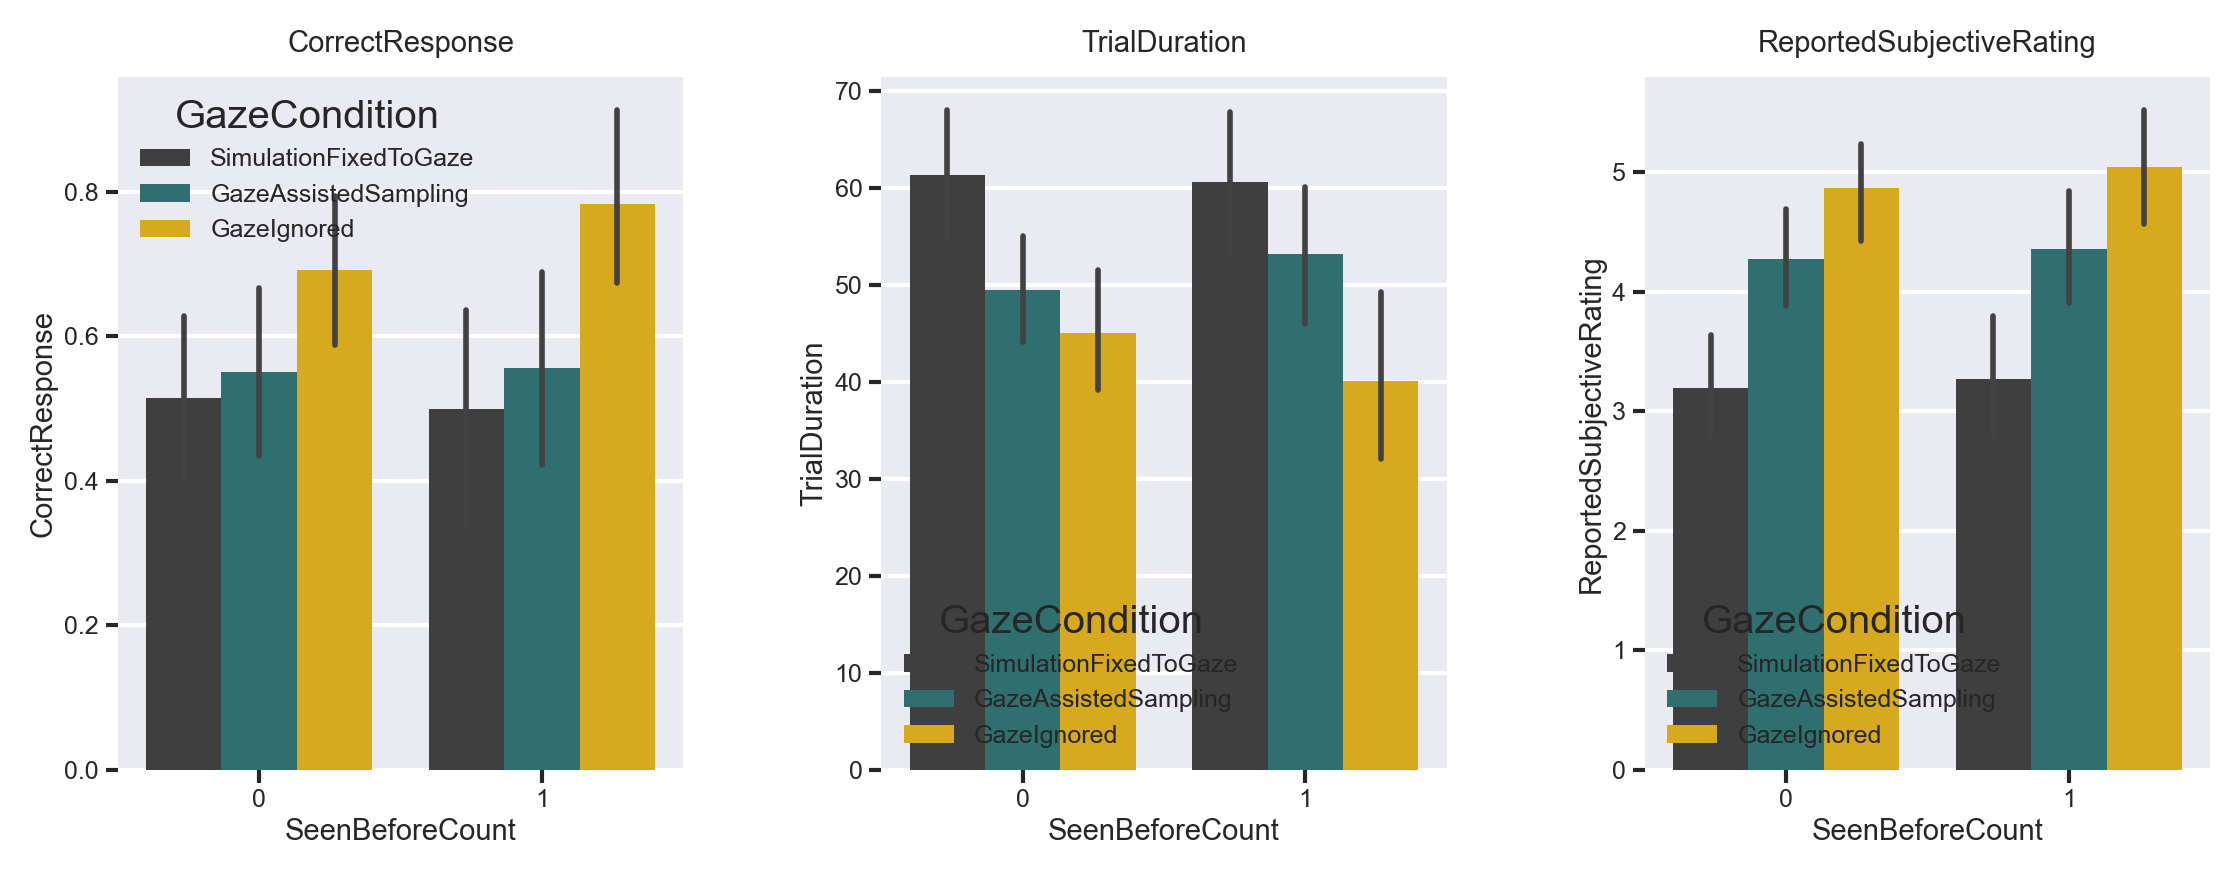

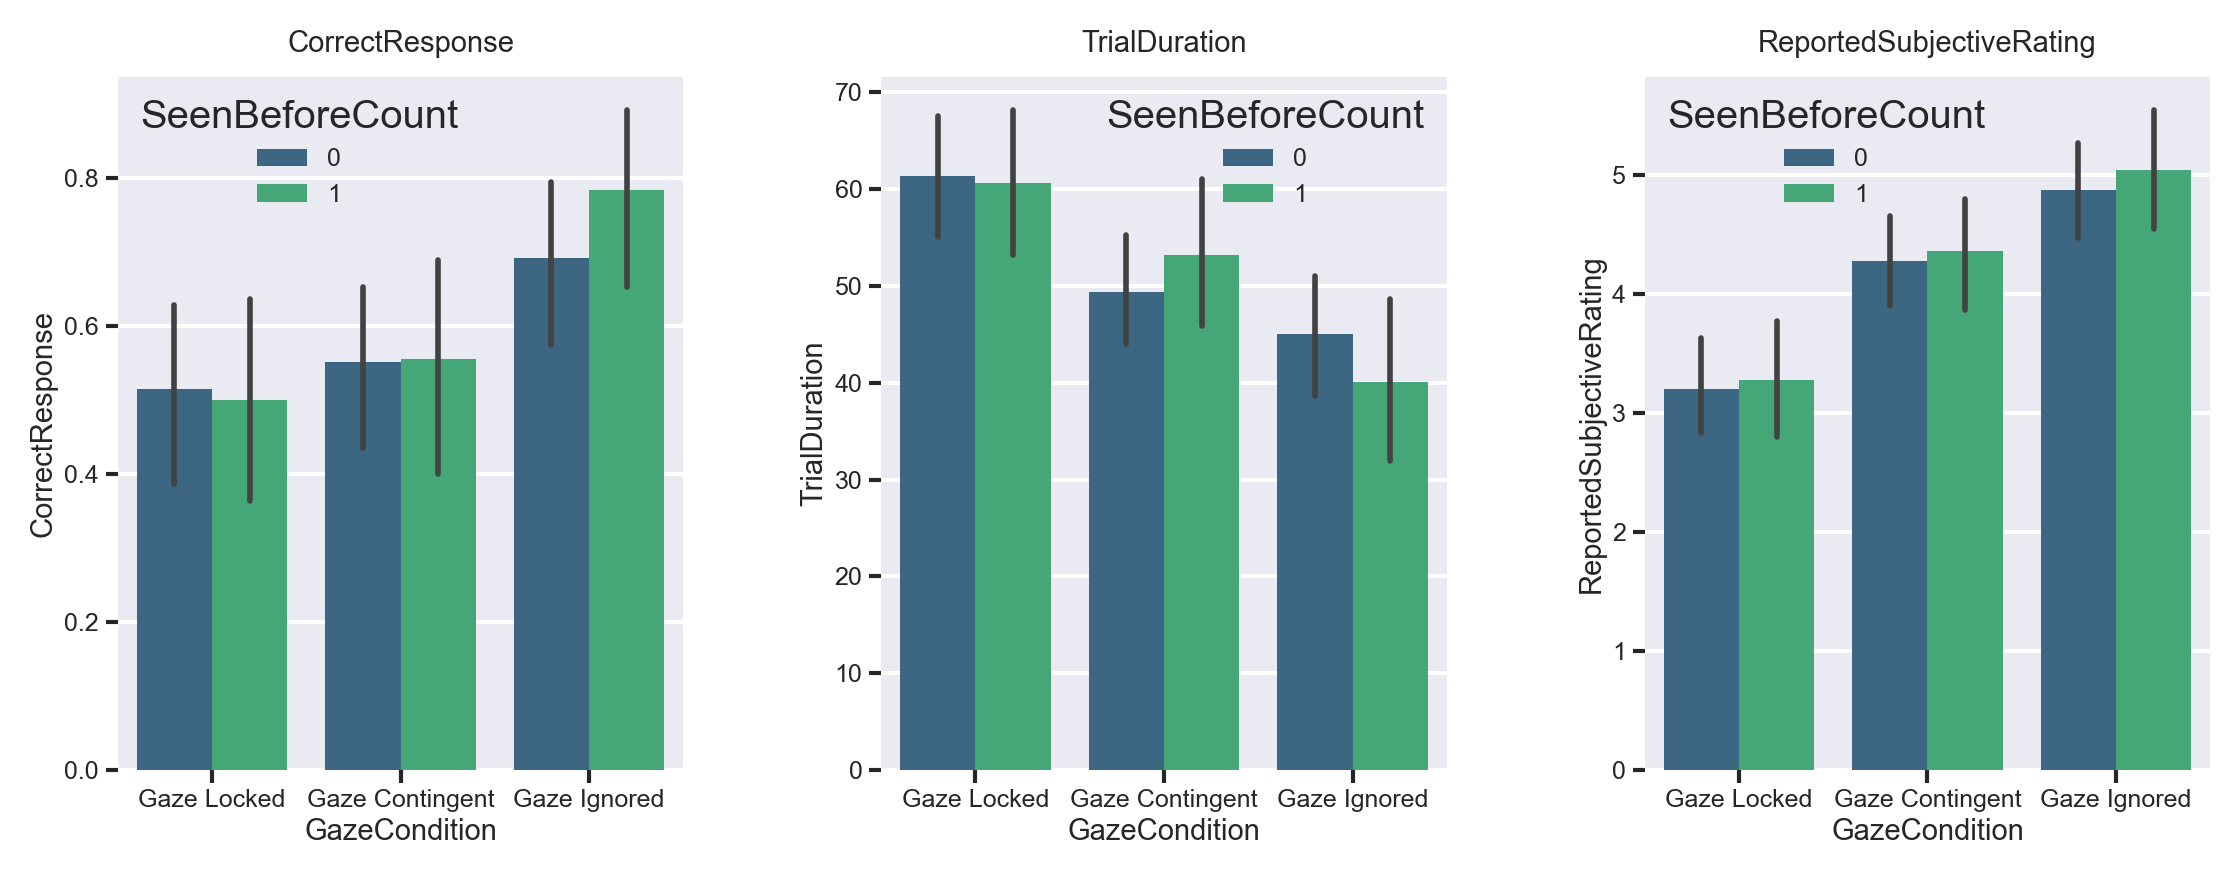

In [37]:
fig, axs = visualization.create_subplots(figsize=(9,3))
visualization.bar_plots(data=sr_data,x='SeenBeforeCount', endpoints=endpoints, order=None,
                        hue='GazeCondition', hue_order=visualization.ORDERED_CONDITIONS, fig=fig, axs=axs)

fig, axs = visualization.create_subplots(figsize=(9,3))
visualization.bar_plots(data=sr_data, x='GazeCondition', endpoints=endpoints,
                        hue='SeenBeforeCount', palette='viridis', fig=fig, axs =axs )
visualization.redefine_x_ticks(axs)
plt.show()

<Axes: xlabel='GazeCondition', ylabel='CorrectResponse'>

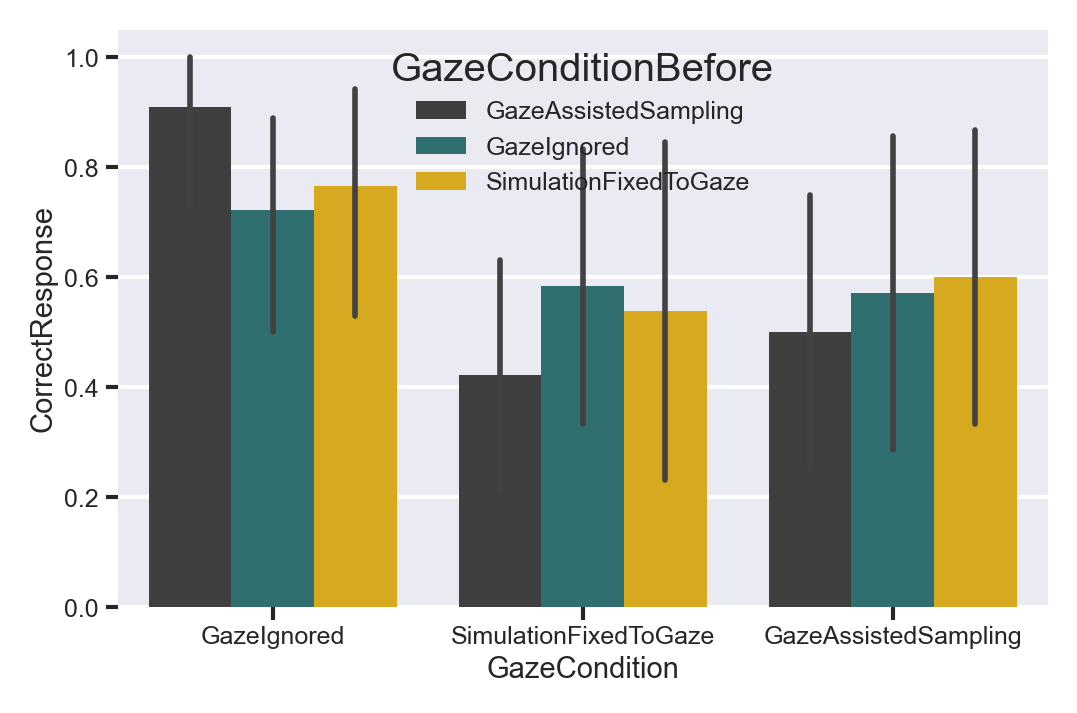

In [48]:
# Effect of previous condition
reindexed = sr_data.set_index(['Subject','EnvironmentName'])
first_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 0].copy()
second_sight = reindexed.loc[reindexed['SeenBeforeCount'] == 1].copy() #pun not intended
before = first_sight.loc[second_sight.index]

second_sight['GazeConditionBefore'] = before.GazeCondition
second_sight['SameConditionBefore'] = before.GazeCondition == second_sight.GazeCondition
second_sight['CorrectBefore'] = before.CorrectResponse
second_sight['CorrectImprovement'] = before.CorrectResponse

fig, ax = visualization.create_subplots(figsize=(4,2.5), n_figs=1)
sns.barplot(data=second_sight,x='GazeCondition', y='CorrectResponse', hue='GazeConditionBefore', ax=ax)